In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm 
from glob import glob
from skimage.io import imread
from skimage.measure import label, regionprops_table
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def print_evaluate(true, predicted):  
    
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def run_all_regressions(X_train, X_test, Y_train, Y_test, regs):

    for name, model in regs.items():

        model.fit(X_train, Y_train)
        
        print(f'\n-----{name}------')
        print('[Train] -------------')
        print_evaluate(Y_train, model.predict(X_train))

        print('[Test] --------------')
        print_evaluate(Y_test, model.predict(X_test))
        
def extract_props_from_image(mask):
    
    label_image = label(mask)

    feature_names = ['bbox_area',
                     'solidity',
                     'equivalent_diameter', 
                     'orientation',
                     'convex_area', 
                     'area',
                     'extent',
                     'eccentricity',
                     'major_axis_length',
                     'feret_diameter_max',
                     'perimeter',
                     'minor_axis_length']
    
    return pd.DataFrame(regionprops_table(label_image, properties=feature_names))

def labeling_dataset(pd_features, weights_filepath):

    pd_dataset = pd_features.copy()
    
    broilers_weights = pd.read_csv(weights_filepath)

    pd_dataset['target'] = -1

    for anilha, peso in zip(broilers_weights.anilhas,  broilers_weights.pesos):

        try: 
            index, *_ = pd_dataset[pd_dataset.label == anilha].index
            pd_dataset.target.iloc[index] = peso
        except:
            continue

    pd_dataset.label.apply(lambda value: value in broilers_weights.anilhas.to_list())

    pd_dataset.drop(pd_dataset[pd_dataset.target < 1].index, inplace=True)

    return pd_dataset

def build_features_dataset(origin_images):
    system_bar = define_barra_path()
    out = pd.DataFrame()

    for path_mask in tqdm(glob(origin_images + f"{system_bar}*")):
        try:
            mask = imread(path_mask)

            props = extract_props_from_image(mask)
            label_name = path_mask.split(system_bar)[-1].split('.')[0]
            props['label'] = int(label_name)

            out = pd.concat([out, props], ignore_index=True)
        
        except Exception as e:
            print("Erro na imagem:", e, end="\n")
            break
            
    return out

def define_barra_path():
    import os
    barra = "/"
    
    if os.name == 'nt':
        barra = "\\"
        
    return barra

In [4]:
features = build_features_dataset("auto_selected_masks")
features_labeling = labeling_dataset(features, "galinhas_pesos.csv")

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 151.95it/s]


In [5]:
features_labeling.head()

,bbox_area,solidity,equivalent_diameter,orientation,convex_area,area,extent,eccentricity,major_axis_length,feret_diameter_max,perimeter,minor_axis_length,label,target
0,11160,0.880061,85.474256,-0.970230,6520,5738,0.514158,0.890681,131.526979,144.803315,381.261977,59.796035,2,1168
1,4650,0.913019,63.950336,-0.053025,3518,3212,0.690753,0.873748,93.449333,94.540996,252.409163,45.451842,3,1275
2,8362,0.869817,78.208969,-0.327122,5523,4804,0.574504,0.866237,116.379801,123.166554,331.178716,58.147144,4,1575
3,14319,0.909779,105.688838,-0.539119,9643,8773,0.612682,0.844968,147.578779,150.602125,447.605122,78.927621,5,1871
4,4810,0.886567,64.495532,-0.678842,3685,3267,0.679210,0.472407,72.057668,75.802375,280.793939,63.510209,7,1520


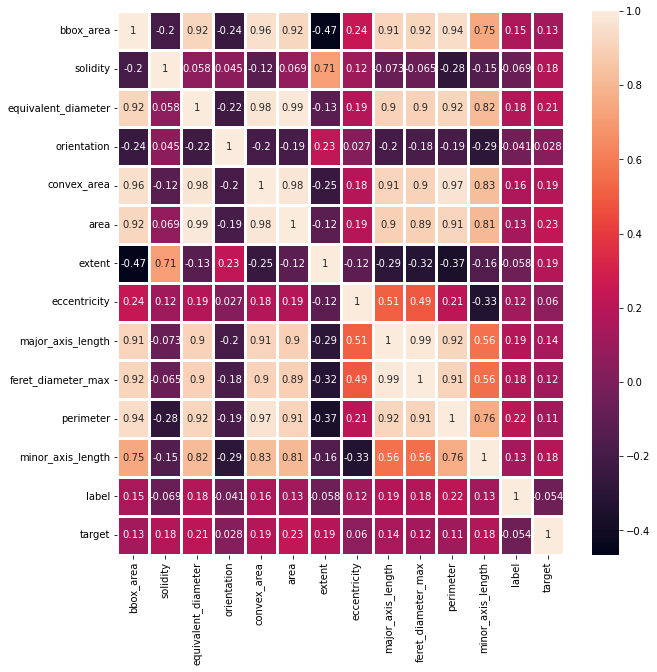

In [6]:
_, ax = plt.subplots(figsize=(10, 10))
corrmat = features_labeling.corr()
sns.heatmap(corrmat, linewidths=3, annot=True);

In [7]:
corrmat[corrmat.target > 0.15].target

solidity               0.179055
equivalent_diameter    0.212369
convex_area            0.190302
area                   0.227943
extent                 0.190963
minor_axis_length      0.181035
target                 1.000000
Name: target, dtype: float64

In [20]:
features_names = list(dict(corrmat[corrmat.target >= 0.15].target).keys())

X = features_labeling[features_names].drop(labels=['target'], axis=1)
y = features_labeling.target

X_train, X_test, y_train, y_test = train_test_split(X.values, 
                                                    y.values, 
                                                    test_size=0.3,
                                                    random_state=0)

scaler = StandardScaler()

scaled_x_train = scaler.fit_transform(X_train)
scaled_x_test = scaler.transform(X_test)

In [18]:
features_names

['solidity',
 'equivalent_diameter',
 'convex_area',
 'area',
 'extent',
 'minor_axis_length',
 'target']

In [19]:
run_all_regressions(scaled_x_train, 
                    scaled_x_test,
                    y_train,
                    y_test,
                    regs = {
                        "rf":RandomForestRegressor(),
                        "Lasso": Lasso(), 
                        "LinearRegression": LinearRegression(),
                        "Ridge": Ridge(),
                        "BayesianRidge": BayesianRidge(), 
                        "ElasticNet": ElasticNet(), 
                        "SGDRegressor": SGDRegressor()
                    })


-----rf------
[Train] -------------
MAE: 83.45942857142859
MSE: 12877.824168571431
RMSE: 113.48050127035671
R2 Square 0.8640237869931388
[Test] --------------
MAE: 243.07933333333327
MSE: 88587.49622666667
RMSE: 297.63651695762513
R2 Square -0.12622390813326412

-----Lasso------
[Train] -------------
MAE: 231.40009548943266
MSE: 83222.07873580535
RMSE: 288.4823716205296
R2 Square 0.1212628036441824
[Test] --------------
MAE: 227.51240050680536
MSE: 76864.41813057306
RMSE: 277.2443293028246
R2 Square 0.02281304844751908

-----LinearRegression------
[Train] -------------
MAE: 227.96677834565406
MSE: 82766.89558177041
RMSE: 287.69236274494745
R2 Square 0.12606905668040902
[Test] --------------
MAE: 239.35691418517516
MSE: 84534.20676283598
RMSE: 290.74766854239084
R2 Square -0.07469393273955105

-----Ridge------
[Train] -------------
MAE: 235.18734818933947
MSE: 84811.85612814083
RMSE: 291.224751915322
R2 Square 0.1044764345725131
[Test] --------------
MAE: 216.0286739613938
MSE: 72406.7